# Artificial Neural Network
In this notebook we will construct an ann and use pso


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
import random

i = 1
print(i)

1


In [3]:
#defining the activation functions using pseudo code in coursework materials
class Activation:
    @staticmethod
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def relu(x):
        return np.maximum(0,x)
    
    @staticmethod
    def tanh(x):
        return np.tanh(x)

In [7]:
Data = pd.read_csv("../Data/data_banknote_authentication.csv", header=None)
Data.columns = ['In1', 'In2', 'In3', 'In4', 'Output']

# Split the dataset into inputs and outputs
X = Data[['In1', 'In2', 'In3', 'In4']]
input_data = X.to_numpy()
y = Data['Output']         

# Sample Data
# 2.6606,3.1681,1.9619,0.18662,0
# 3.931,1.8541,-0.023425,1.2314,0
# 0.01727,8.693,1.3989,-3.9668,0
# 3.2414,0.40971,1.4015,1.1952,0
# 2.2504,3.5757,0.35273,0.2836,0
# -1.3971,3.3191,-1.3927,-1.9948,1
# 0.39012,-0.14279,-0.031994,0.35084,1
# -1.6677,-7.1535,7.8929,0.96765,1
# -3.8483,-12.8047,15.6824,-1.281,1
# -3.5681,-8.213,10.083,0.96765,1
# -2.2804,-0.30626,1.3347,1.3763,1

    
# defining the ANN class
class ANN:
    # defining the create function with all empty lists 
    def __init__(self, layers):
        self.layers = layers
        self.weights = []
        self.biases = []
        self.act_function = 0  
    
    def forwardFunction(self, input_data):
        # Start with the input sample
        predictions = []

        for row in input_data:
            activation = row
            # Iterate through layers and compute activations
            for i in range(len(self.layers) - 2):
                # Calculate weighted input plus bias
                activation = np.dot(activation, self.weights[i]) + self.biases[i]
                if self.act_function <= 0.33:
                    activation = Activation.sigmoid(activation)
                elif self.act_function <= 0.667:
                    activation = Activation.relu(activation)
                else:
                    activation = Activation.tanh(activation)
            
            activation = np.dot(activation, self.weights[-1]) + self.biases[-1]
            activation = Activation.sigmoid(activation)

            predicted_class = 1 if activation >= 0.5 else 0
            predictions.append(predicted_class)
        # The final activation is the output
        return predictions

    def decode(self, encoded_vector):
        # Pointer to keep track of where we are in the encoded vector
        pointer = 0
        new_weights = []
        new_biases = []

        # Extract all the weights from the vector
        for i in range(len(self.layers) - 1):
            # Calculate the number of weights for this layer
            layer_weights_count = self.layers[i] * self.layers[i+1]
            # Slice out the weights for this layer
            layer_weights = encoded_vector[pointer:pointer+layer_weights_count]
            # Reshape the weights to the correct dimensions and append to new_weights
            new_weights.append(layer_weights.reshape(self.layers[i], self.layers[i+1]))
            # Move the pointer by the number of weights we just processed
            pointer += layer_weights_count

        # Extract all the biases from the vector
        for i in range(1, len(self.layers)):
            layer_biases_count = self.layers[i]
            layer_biases = encoded_vector[pointer:pointer+layer_biases_count]
            new_biases.append(layer_biases)
            pointer += layer_biases_count

        # The last element is the activation function type
        act_function = encoded_vector[-1]

        # Update the ANN's parameters
        self.weights = new_weights
        self.biases = new_biases
        self.act_function = act_function

    @staticmethod
    def calculate_accuracy(y_true, y_pred):
        correct_predictions = np.sum(y_true == y_pred)
        accuracy = correct_predictions / len(y_true)
        return accuracy


    @staticmethod
    def initialise_ann(ann): # creating random weights and bias for each layer
            for i in range(len(ann.layers) - 1):
                ann.weights.append(np.random.rand(ann.layers[i], ann.layers[i+1]))
                ann.biases.append(np.zeros(ann.layers[i+1]))
            ann.act_function = random.random()
    



In [28]:
example = ANN([4,1, 2,1])


ANN.initialise_ann(example)
# Running the forward function for each row in the data and collecting predictions

predictions = example.forwardFunction(input_data)

# Calculate the accuracy
accuracy = ANN.calculate_accuracy(y_true=y.values, y_pred=np.array(predictions))
print(f"Accuracy: {accuracy}")

# Ensure that y is a numpy array
actual_labels = y.values

# print(predictions)
# print(actual_labels)

# Calculate the F1 score
f1 = f1_score(actual_labels, predictions, average='binary')
print(f"F1 Score: {f1}")
# Displaying initialized weights and biases
print("Weights:")
for w in example.weights:
    print(w)
    print()


Accuracy: 0.13848396501457727
F1 Score: 0.14718614718614717
Weights:
[[0.81803102]
 [0.30950118]
 [0.43391853]
 [0.83500166]]

[[0.40194176 0.57386065]]

[[0.72708878]
 [0.32463462]]



Multiple Swarms (Group-Based Informants)
Description:

Each subgroup (mini-swarm) operates semi-independently.
Particles within a subgroup share information with each other.
All subgroups are aware of the global best position.
Pros:

Encourages deep search within subgroups.
Maintains diversity since different subgroups may explore different regions.
Prevents premature convergence to a single solution.
Cons:

May require more iterations for the entire swarm to converge on the global best.
Subgroups may get isolated in local optima.

In [69]:
class Particle:
    def __init__(self, ann, upper_bound_bias_value, lower_bound_bias_value, upper_bound_weight_value, lower_bound_weight_value):
        self.position = self.initialise_position(ann, upper_bound_bias_value, lower_bound_bias_value, upper_bound_weight_value, lower_bound_weight_value)
        self.velocity = self.initialise_velocity()
        self.p_best = (0, np.zeros(self.position.shape))
        self.i_best = (0, np.zeros(self.position.shape))
        self.fitness = 0
        self.informant_group = []
        self.lower_bound, self.upper_bound = Particle.create_pso_bounds(ann.layers,upper_bound_bias_value,lower_bound_bias_value,upper_bound_weight_value,lower_bound_weight_value )


    def initialise_position(self, ann, upper_bound_bias_value, lower_bound_bias_value, upper_bound_weight_value, lower_bound_weight_value):
        weights = []
        biases = []
        for i in range(len(ann.layers) - 1):
            # Generate random weights in the specified range
            weights.append(np.random.uniform(lower_bound_weight_value, upper_bound_weight_value, size=(ann.layers[i], ann.layers[i+1])))
            # Generate random biases in the specified range
            biases.append(np.random.uniform(lower_bound_bias_value, upper_bound_bias_value, size=ann.layers[i+1]))
        # Random activation function value
        act_function = random.random()
        return Particle.encode(weights, biases, act_function)
    
# Look into if the weights need to add up to 1 or if there can be a set of weights that sum >1
        
    def initialise_velocity(self):
        return np.zeros(self.position.shape)   
# Look into starting with random velocities

    @staticmethod
    def encode(weights, biases, act_function):
        # Flatten and concatenate all the weights and biases
        flattened_weights = [w.flatten() for w in weights]
        flattened_biases = [b.flatten() for b in biases]
        
        # Concatenate weights and then biases into one vector
        encoded_vector = np.concatenate(flattened_weights + flattened_biases)
        
        # Append the activation function type
        encoded_vector = np.append(encoded_vector, act_function)

        return encoded_vector
        

    def calc_fitness(self, ann):
        predictions = ann.forwardFunction(input_data)
        self.fitness = ANN.calculate_accuracy(y.values, np.array(predictions))
        

    def find_fitness(self, ann): 
        ann.decode(self.position)
        self.calc_fitness(ann)
        
        #  (self.global_best[1], self.prop_cur_velocity, self.cog_component, self.social_component, self.prop_p_best, self.prop_info_best, self.prop_global_best)

    def update_velocity(self, global_best_position, prop_cur_velocity, prop_p_best, prop_info_best, prop_global_best):
        # Scale random factors based on the defined proportions
        r1 = np.random.uniform(0, prop_p_best)
        r2 = np.random.uniform(0, prop_info_best)
        r3 = np.random.uniform(0, prop_global_best)
        cognitive_component =  r1 * (self.p_best[1] - self.position)
        social_component = r2 * (self.i_best[1] - self.position)
        global_component = r3 * (global_best_position - self.position)
        inertia_component = prop_cur_velocity * self.velocity
        self.velocity = inertia_component + cognitive_component + social_component + global_component
# Constrain r1, r2 to Proportions defined in the Swarm

    def update_position(self):
        self.position += self.velocity
        for i in range(len(self.position)):
            if self.position[i] < self.lower_bound[i] or self.position[i] > self.upper_bound[i]:
                # Reset the position to a random value within the bounds
                self.position[i] = np.random.uniform(self.lower_bound[i], self.upper_bound[i])

    @staticmethod
    def create_pso_bounds(layers, upper_bound_bias_value,lower_bound_bias_value,upper_bound_weight_value,lower_bound_weight_value):
        total_weights = sum(layers[i] * layers[i + 1] for i in range(len(layers) - 1))
        total_biases = sum(layers[i + 1] for i in range(len(layers) - 1))

        # Weights bounds
        lower_weights = np.full(total_weights,  lower_bound_weight_value)
        upper_weights = np.full(total_weights, upper_bound_weight_value)

        # Biases bounds
        lower_biases = np.full(total_biases, lower_bound_bias_value)
        upper_biases = np.full(total_biases, upper_bound_bias_value)

        # Activation function bounds (single value)
        lower_activation = np.array([0])
        upper_activation = np.array([1])

        # Combine all bounds
        lower_bound = np.concatenate([lower_weights, lower_biases, lower_activation])
        upper_bound = np.concatenate([upper_weights, upper_biases, upper_activation])

        return lower_bound, upper_bound
        


In [70]:
class Swarm:
    def __init__(self, ann_structure, swarm_size, prop_cur_velocity, prop_p_best, prop_info_best, prop_global_best, jump_size, lower_bound_bias,lower_bound_weight, upper_bound_bias, upper_bound_weight):
        self.ann = ANN(ann_structure)
        self.swarm_size = swarm_size
        self.prop_cur_velocity = prop_cur_velocity
        self.prop_p_best = prop_p_best
        self.prop_info_best = prop_info_best
        self.prop_global_best = prop_global_best
        self.jump_size = jump_size
        self.lower_bound_bias_value = lower_bound_bias
        self.upper_bound_bias_value = upper_bound_bias
        self.lower_bound_weight_value = lower_bound_weight
        self.upper_bound_weight_value = upper_bound_weight
        self.particles = self.initialize_swarm()
        self.global_best = (0, np.zeros(self.particles[0].position.shape))


        

    def initialize_swarm(self):
        # Initialize particles
        particles = [Particle(self.ann, self.upper_bound_bias_value, self.lower_bound_bias_value, self.upper_bound_weight_value, self.lower_bound_weight_value) for _ in range(self.swarm_size)]
        # Assign informant groups to each particle
        for particle in particles:
            particle.informant_group = self.assign_informant_group(particle, particles)
        return particles
    
# P1.informats = [p1, p2, p5, p63]
# P2.informats = [p2, p3, p7, p23]

    def assign_informant_group(self, current_particle, particles):
        informant_group_size = 5 # Define the size of the informant group
        informant_group = [current_particle]  # Include the particle itself
        while len(informant_group) < (informant_group_size + 1):  # Adjust size accordingly
            potential_informant = random.choice(particles)
            if potential_informant not in informant_group:
                informant_group.append(potential_informant)
        return informant_group
    
    
    def assign_fitnesses_and_bests(self):
        # Calculate fitness for all particles
        for particle in self.particles:           
            particle.find_fitness(self.ann)
            if particle.fitness > particle.p_best[0]:
                    particle.p_best = (particle.fitness, particle.position)
        # Find the best informant of the group and the best particle overall
        for particle in self.particles:       
            # Update informant group best

            info_best = max(particle.informant_group, key=lambda p: p.p_best[0])
            particle.i_best = (info_best.p_best[0], info_best.p_best[1])
            #update value every time as is more efficient than checking for increase in fitness and then updating
            
            if particle.fitness > self.global_best[0]:
                self.global_best = (particle.fitness, particle.position)


    def optimise_graph(self, max_iterations, w, c1, c2):
        # Initialize the swarm
        global_best_list = []

        for iteration in range(max_iterations):
            
            # Evaluate fitness and update personal and informant bests
            self.assign_fitnesses_and_bests()
            
            # Update particle velocities and positions
            for particle in self.particles:
                particle.update_velocity(self.global_best[1], w, c1, c2)
                
            for particle in self.particles:
                particle.update_position()

            # Optional: Print current global best for monitoring
            # print(f"Iteration {iteration}, Global Best Fitness: {self.global_best[0]}, Activation: {self.global_best[1][-1]}, {int(np.round(self.global_best[1][-1])) % 3}" )
            global_best_list.append(self.global_best[0])


        return global_best_list
    
    def optimise(self, max_iterations):
        # Initialize the swarm
        
        best_fitness = 0  # Initialize to a very low value
        iterations_since_improvement = 0  # Counter for iterations since last improvement

        for iteration in range(max_iterations):
            
            # Evaluate fitness and update personal and informant bests
            self.assign_fitnesses_and_bests()
            
            # Check for improvement
            if self.global_best[0] > best_fitness:
                best_fitness = self.global_best[0]
                iterations_since_improvement = 0  # Reset the counter
            else:
                iterations_since_improvement += 1  # Increment the counter

            # Check if convergence criteria is met
            if iterations_since_improvement >= 15:
                break

            # Update particle velocities and positions
            for particle in self.particles:
                particle.update_velocity(self.global_best[1], self.prop_cur_velocity, self.prop_p_best, self.prop_info_best, self.prop_global_best)
                
            for particle in self.particles:
                particle.update_position()

            # Optional: Print current global best for monitoring
            # print(f"Iteration {iteration}, Global Best Fitness: {self.global_best[0]}, Activation: {self.global_best[1][-1]}, {int(np.round(self.global_best[1][-1])) % 3}" )


        return self.global_best

    

In [71]:
# Usage example
ann_structure = [4,1, 1]  # Example ANN structure
best_structure =[]
best_accuracy = 0

# ann_structure, swarm_size, prop_cur_velocity, prop_p_best, prop_info_best, prop_global_best, jump_size)
swarm = Swarm(ann_structure, swarm_size=100, prop_cur_velocity=0.5, prop_p_best=0.5, prop_info_best=0.1, prop_global_best=0, jump_size=1, upper_bound_bias= 10 , lower_bound_bias=-10, upper_bound_weight=5, lower_bound_weight=-5)
result = swarm.optimise(max_iterations=60)

print(f"Global Best Fitness: {result[0]}")


/var/folders/qc/frf5n2ls2j1fpj5j4fzztqh00000gq/T/ipykernel_25208/3857168004.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Global Best Fitness: 0.9927113702623906, 
 [array([[1.63024892],
       [1.27920184],
       [1.40302852],
       [0.12231077]]), array([[-1.52153047]])]


In [111]:
for w in swarm.ann.weights:
    print(w)
    print()


[[1.16266971]
 [1.60558194]
 [0.97120654]
 [1.06928502]]

[[-0.98401809]]



In [73]:
ann_structure = [4, 1, 1]  # Example ANN structure
fitness_results = []
positions = []

for _ in range(10):
    swarm = Swarm(ann_structure, swarm_size=70, prop_cur_velocity=0.5, prop_p_best=0.5, prop_info_best=0.1, prop_global_best=0, jump_size=1, upper_bound_bias= 10 , lower_bound_bias=-10, upper_bound_weight=5, lower_bound_weight=-5)
    result = swarm.optimise(max_iterations=75)
    fitness_results.append(result[0])
    positions.append(result[1])

# Calculate average and standard deviation
average_fitness = np.mean(fitness_results)
std_dev_fitness = np.std(fitness_results)

print(f"Average Global Best Fitness: {average_fitness}")
print(f"Standard Deviation of Fitness: {std_dev_fitness}")


Average Global Best Fitness: 0.9726676384839651
Standard Deviation of Fitness: 0.022356616816902194


In [ ]:
for res, pos in zip(fitness_results, positions):
    print(res)
    print(pos)


Random Informant Selection
Description:

Each particle has a random selection of other particles as informants, in addition to knowing the global best.
Pros:

Increases diversity by introducing randomness.
Particles have the chance to be influenced by potentially distant regions of the search space.
Cons:

Could lead to erratic behavior and potentially slow down convergence.
Managing and updating a random set of informants can be computationally more expensive.

Code that tests the rate of optimisation

[0.3141399416909621, 0.8935860058309038, 0.9125364431486881, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533, 0.9635568513119533,

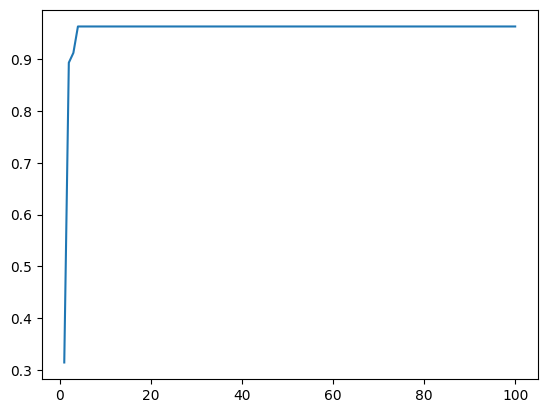

3


In [ ]:
# Usage example

ann_structure = [4,4,5, 1]  # Example ANN structure
best_structure =[]
best_accuracy = 0

max_iterations=100
list_iter = np.arange(1,max_iterations+1).tolist()
swarm = Swarm(ann_structure, swarm_size=100, prop_cur_velocity=0.1, prop_p_best=0.1, prop_info_best=0.1, prop_global_best=0.1, jump_size=1)
result = swarm.optimise_graph(max_iterations, w=0.5, c1=1.0, c2=1.0)
print(result)
plt.plot(list_iter,result)
plt.show()


def find_last_increase(g_best_list):
    for i in range(len(g_best_list)-1, 0, -1):
        if g_best_list[i] > g_best_list[i-1]:
            return i
    return i

print(find_last_increase(result))
#returs 45
# for iteration in range(10):
# print(f"Iteration {iteration}, Global Best Fitness: {result[0]}, Activation: {result[1][-1]}, {int(np.round(result[1][-1])) % 3}" )
# print(result)

Code that Tests Architecture Don't think we need

In [ ]:
from itertools import product
from itertools import combinations_with_replacement

def generate_lists(size, start, end):
    numbers = list(range(start, end + 1))
    best_accuracy = 0
    best_structure = []
    count = 0
    # Generate all possible permutations of 'size' elements with repetition
    for i in range(size):
        print(i)
        permutations = list(product(numbers, repeat=i+1))
        lists_of_size = [list(lst) for lst in permutations]
        for i in range(len(lists_of_size)):
            print(lists_of_size[i])
            lists_of_size[i].insert(0, 4)
            lists_of_size[i].append(1)
            swarm = Swarm(lists_of_size[i], swarm_size=100, prop_cur_velocity=0.1, prop_p_best=0.1, prop_info_best=0.1, prop_global_best=0.1, jump_size=1 )
            result = swarm.optimise(max_iterations =50, w=0.5, c1=1.0, c2=1.0)
            count += 1
            if result[0] > best_accuracy:
                print(result[0])
                best_accuracy = result[0]
                best_structure = lists_of_size[i]
    
    print(count)                                           
    best_overall = (best_accuracy, best_structure)
    return best_overall
    
    



# Example usage
size = 2
start_value = 1  
max_value = 7  
answer = generate_lists(size, start_value, max_value)
print(answer)






0
[1]
0.9285714285714286
[2]
[3]


KeyboardInterrupt: 

code to test architecture


0
[1]
0.8760932944606414
-------------------------------------------
0.8760932944606414
[2]
0.8381924198250729
[3]
0.9139941690962099
-------------------------------------------
0.9139941690962099
[4]
0.9307580174927114
-------------------------------------------
0.9307580174927114
[5]
0.9438775510204082
-------------------------------------------
0.9438775510204082
[6]
0.9169096209912536
[7]
0.7959183673469388
1
[1, 1]
0.7230320699708455
[1, 2]
0.9322157434402333
[1, 3]
0.9555393586005831
-------------------------------------------
0.9555393586005831
[1, 4]
0.989067055393586
-------------------------------------------
0.989067055393586
[1, 5]
0.9533527696793003
[1, 6]
0.9526239067055393
[1, 7]
0.9817784256559767
[2, 1]
0.9489795918367347
[2, 2]
0.9395043731778425
[2, 3]


C:\Users\ewan_\AppData\Local\Temp\ipykernel_16244\2977491065.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


0.8899416909620991
[2, 4]
0.9307580174927114
[2, 5]
0.922740524781341
[2, 6]
0.9249271137026239
[2, 7]
0.9365889212827988
[3, 1]
0.9555393586005831
[3, 2]
0.4467930029154519
[3, 3]
0.934402332361516
[3, 4]
0.9686588921282799
[3, 5]
0.8469387755102041
[3, 6]
0.9650145772594753
[3, 7]
0.9504373177842566
[4, 1]
0.5553935860058309
[4, 2]
0.9504373177842566
[4, 3]
0.9482507288629738
[4, 4]
0.9336734693877551
[4, 5]
0.9912536443148688
-------------------------------------------
0.9912536443148688
[4, 6]
0.9198250728862973
[4, 7]
0.532798833819242
[5, 1]
0.978134110787172
[5, 2]
0.7135568513119533
[5, 3]
0.9431486880466472
[5, 4]
0.9482507288629738
[5, 5]
0.9293002915451894
[5, 6]
0.4446064139941691
[5, 7]
0.9424198250728864
[6, 1]
0.8935860058309038
[6, 2]
0.8498542274052479
[6, 3]
0.9584548104956269
[6, 4]
0.9701166180758017
[6, 5]
0.9868804664723032
[6, 6]
0.9482507288629738
[6, 7]
0.967201166180758
[7, 1]
0.935131195335277
[7, 2]
0.9817784256559767
[7, 3]
0.9774052478134111
[7, 4]
0.96720

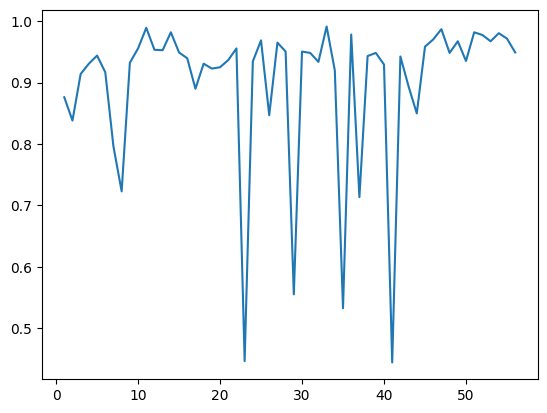

(0.9912536443148688, [4, 4, 5, 1])


In [ ]:
from itertools import product
from itertools import combinations_with_replacement


def generate_lists(size, start, end):
    numbers = list(range(start, end + 1))
    best_accuracy = 0
    best_structure = []
    collection_of_results = []
    collection_of_list = []
    count = 0
    # Generate all possible permutations of 'size' elements with repetition
    for i in range(size):
        print(i)
        permutations = list(product(numbers, repeat=i+1))
        lists_of_size = [list(lst) for lst in permutations]
        for i in range(len(lists_of_size)):
            print(lists_of_size[i])
            lists_of_size[i].insert(0, 4)
            lists_of_size[i].append(1)
            swarm = Swarm(lists_of_size[i], swarm_size=100, prop_cur_velocity=0.1, prop_p_best=0.1, prop_info_best=0.1, prop_global_best=0.1, jump_size=1 )
            result = swarm.optimise(max_iterations=50)
            count += 1
            print(result[0])
            collection_of_list.append(lists_of_size[i])
            collection_of_results.append(result[0])
            if result[0] > best_accuracy:
                print("-------------------------------------------")
                print(result[0])
                best_accuracy = result[0]
                best_structure = lists_of_size[i]
    list_iter = np.arange(1,count+1).tolist()
    lists_of_strings = [''.join(map(str, sublist)) for sublist in collection_of_list]                                       
    plt.plot(list_iter,collection_of_results)
    plt.show()

    best_overall = (best_accuracy, best_structure)

    return best_overall
    
    



# Example usage
size = 2
start_value = 1  
max_value = 7  
answer = generate_lists(size, start_value, max_value)
print(answer)


Code to test Different Swarm sizes

In [74]:
import numpy as np
import matplotlib.pyplot as plt

ann_structure = [4, 4, 1]  # Example ANN structure
swarm_sizes = [20, 30, 40, 50, 60, 70]  # Different swarm sizes to test
average_fitness_results = []
std_dev_fitness_results = []

for size in swarm_sizes:
    fitness_results = []
    for _ in range(10):  # Run each swarm size 10 times
        swarm = Swarm(ann_structure, swarm_size=size, prop_cur_velocity=0.5, prop_p_best=0.5, prop_info_best=0.1, prop_global_best=0, jump_size=1, upper_bound_bias= 10 , lower_bound_bias=-10, upper_bound_weight=5, lower_bound_weight=-5)

        result = swarm.optimise(max_iterations=75)
        fitness_results.append(result[0])

    # Calculate average and standard deviation for each swarm size
    average_fitness = np.mean(fitness_results)
    std_dev_fitness = np.std(fitness_results)

    average_fitness_results.append(average_fitness)
    std_dev_fitness_results.append(std_dev_fitness)

# Plotting
plt.figure(figsize=(10, 5))

# Plot average fitness
plt.subplot(1, 2, 1)
plt.plot(swarm_sizes, average_fitness_results, marker='o')
plt.title("Average Global Best Fitness vs Swarm Size")
plt.xlabel("Swarm Size")
plt.ylabel("Average Global Best Fitness")

# Plot standard deviation of fitness
plt.subplot(1, 2, 2)
plt.plot(swarm_sizes, std_dev_fitness_results, marker='o', color='red')
plt.title("Standard Deviation of Fitness vs Swarm Size")
plt.xlabel("Swarm Size")
plt.ylabel("Standard Deviation of Fitness")

plt.tight_layout()
plt.show()


/var/folders/qc/frf5n2ls2j1fpj5j4fzztqh00000gq/T/ipykernel_25208/3857168004.py:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [ ]:
ann_structure = [4, 4, 5, 1]  # Example ANN structure
fitness_results = []
list_results_fitness = []
list_results_std = []

trial_list = [[10,1,5,10],[-10,-1,-5,-10],[5,1,10,10],[-5,-1,-10,-10]]

for i in range(len(trial_list)):
    print(i)
    fitness_results = []

    for _ in range(10):
        swarm = Swarm(ann_structure, swarm_size=100, prop_cur_velocity=0.5, prop_p_best=0.5, prop_info_best=0.1, prop_global_best=0, jump_size=1, upper_bound_bias= trial_list[0][i], lower_bound_bias=[1][i], upper_bound_weight=[2][i], lower_bound_weight=[3][i])
        result = swarm.optimise(max_iterations=75)

        fitness_results.append(result[0])  # Assuming result[0] is the fitness value
    list_results_fitness.append(np.mean(fitness_results))
    list_results_std.append(np.std(fitness_results))


plt.figure(figsize=(10, 5))

# Plot average fitness
plt.subplot(1, 2, 1)
plt.plot([1,2,3,4], list_results_fitness, marker='o')
plt.title("Average Global Best Fitness vs biases")
plt.xlabel("biases")
plt.ylabel("Average Global Best Fitness")

# Plot standard deviation of fitness
plt.subplot(1, 2, 2)
plt.plot([1,2,3,4], list_results_std, marker='o', color='red')
plt.title("Standard Deviation of Fitness vs biases")
plt.xlabel("biases")
plt.ylabel("Standard Deviation of Fitness")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ann_structure = [4, 1, 1]  # Example ANN structure

# Define different numbers of iterations to test
iterations_to_test = [25, 50, 75, 100]

# Lists to store the results
average_fitness_results = []
std_dev_fitness_results = []

# Test each number of iterations
for max_iterations in iterations_to_test:
    fitness_results = []

    for _ in range(10):  # Run 10 trials for each number of iterations
        swarm = Swarm(ann_structure, swarm_size=70, prop_cur_velocity=0.5, prop_p_best=0.5, prop_info_best=0.1, prop_global_best=0, jump_size=1, upper_bound_bias=10, lower_bound_bias=-10, upper_bound_weight=5, lower_bound_weight=-5)
        result = swarm.optimise(max_iterations=max_iterations)
        fitness_results.append(result[0])

    # Calculate average and standard deviation for this number of iterations
    average_fitness = np.mean(fitness_results)
    std_dev_fitness = np.std(fitness_results)

    average_fitness_results.append(average_fitness)
    std_dev_fitness_results.append(std_dev_fitness)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot average fitness vs. iterations
plt.subplot(1, 2, 1)
plt.plot(iterations_to_test, average_fitness_results, marker='o')
plt.title("Average Global Best Fitness vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Average Global Best Fitness")

# Plot standard deviation of fitness vs. iterations
plt.subplot(1, 2, 2)
plt.plot(iterations_to_test, std_dev_fitness_results, marker='o', color='red')
plt.title("Standard Deviation of Fitness vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Standard Deviation of Fitness")

plt.tight_layout()
plt.show()
